# HW6 by ZIQING HE (1007691348)

## (a)

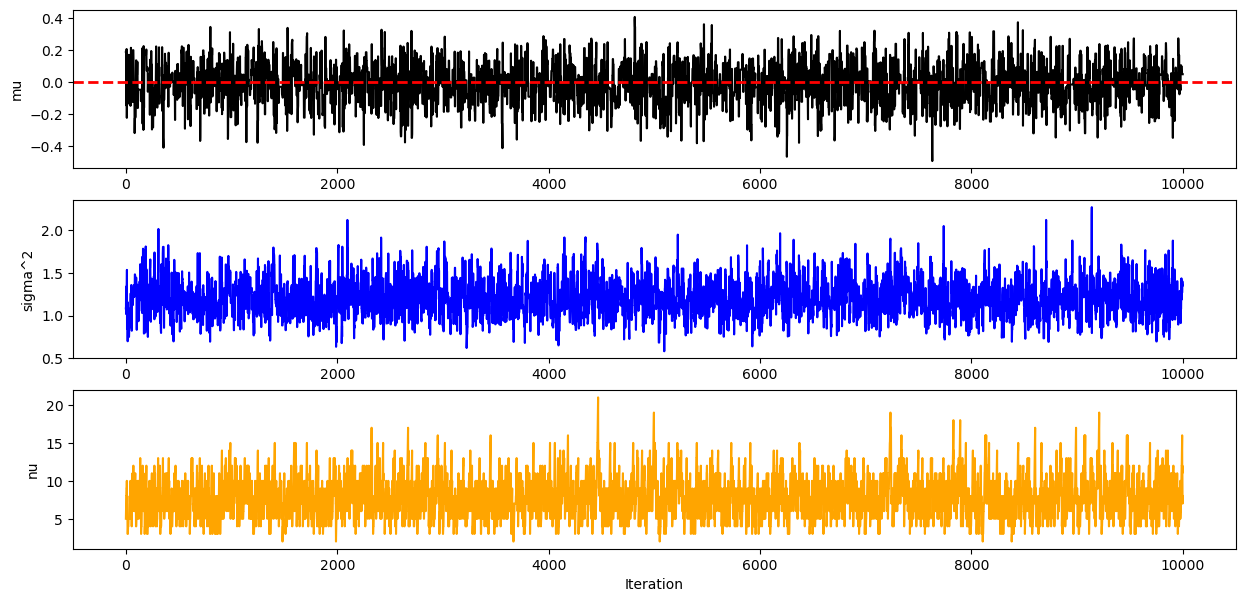

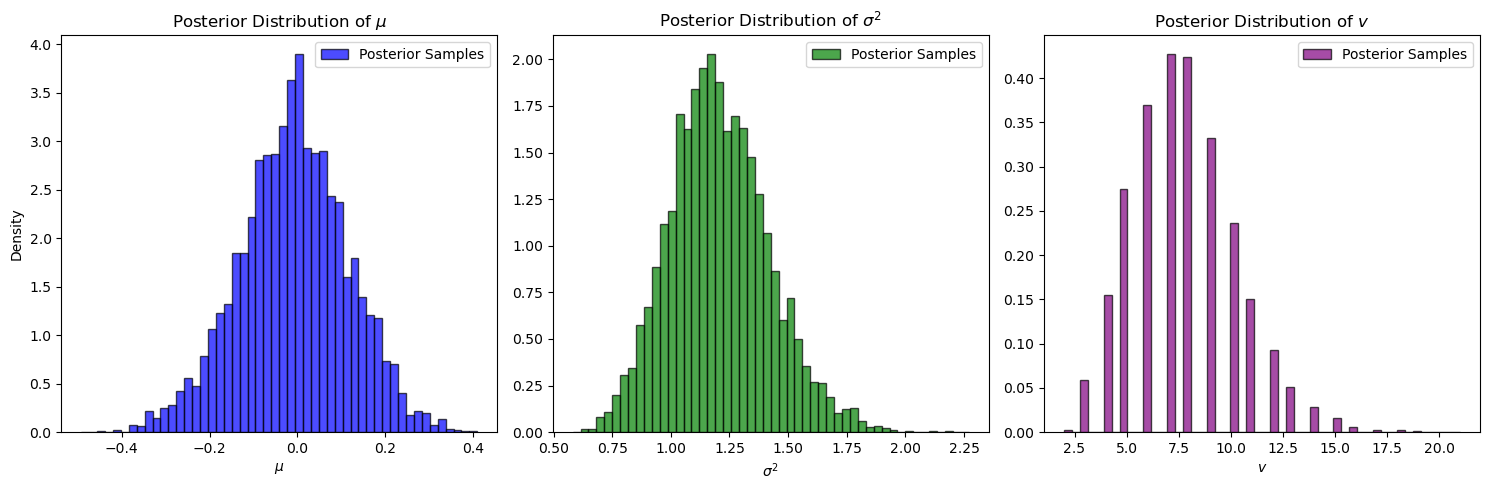

In [48]:
# Q1 

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(10000)
#setting parameters
n = 100 #This is number of sample
true_mu = 0.0
true_var = 1.0
true_df = 5 #The data is generated from t-distribution with df=5 as suggested lower v would have heavier tails, 
            #i.e., more outliers in the data.

x = true_mu + np.sqrt(true_var) * stats.t.rvs(df=true_df, size=n) # generate 100 data from t-distribution with mu=0, sigma^2=1, df(v)=5
#through this way I can ensure the generated sample is center around true mean

#define hyperparameter(prior)
mu0 = 0.0
tau0 = 1.0
sigma0 = 1.0


#define log-posterior function
def log_post(mu, sigma2, nu, x, mu0, tau0, sigma0):
    likelihood = np.sum(gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(np.pi*nu*sigma2) - ((nu+1)/2)*np.log(1 + ((x-mu)**2)/(nu*sigma2)))
    mu_post = 0.5*np.log(tau0/(2*np.pi)) - (tau0/2)*(mu - mu0)**2
    sigma2_post = 0.5*np.log(2/(np.pi*sigma0**2)) - (sigma2**2)/(2*sigma0**2)
    nu_post = np.log(1/100)
    return likelihood + mu_post + sigma2_post + nu_post #Since we are working with log, the multiplication changes to addition.

# Initialize MCMC sampling
iters = 10000 #10000 times iterations
mu_samples = np.zeros(iters) #generate 10000 0's as place holders s.t. later use actula value to substitute it.
sigma2_samples = np.zeros(iters) #same logic
nu_samples = np.zeros(iters, dtype=int) #same logic

# set current state of parameters
mu_current = 0.0
sigma2_current = 1.0
nu_current = 10
log_post_current = log_post(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

#proposal parameter
mu_prop_sd = 0.5
log_sigma2_prop_sd = 0.4

#iteration
for t in range(iters):
    mu_proposal = mu_current + np.random.normal(0, mu_prop_sd) #generate proprosal distribution, with random walk
    log_post_proposal = log_post(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current: # if the generated number from unif[0,1] less than acceptance prob. accept proposal.Otherwise no
        mu_current = mu_proposal
        log_post_current = log_post_proposal
    mu_samples[t] = mu_current

    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    log_post_proposal = log_post(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current + log_sigma2_proposal - log_sigma2_current: # need last two term for correction into the log-space
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal
    sigma2_samples[t] = sigma2_current
    
    nu_proposal = nu_current + np.random.choice([-5, 1])
    if nu_proposal < 1: #t distribution is undefined for v<=0, and if 0<v<1 then the distribution becomes unstable
        nu_proposal = 1
    if nu_proposal > 100: # if too large, then normal-like behaviour
        nu_proposal = 100
    log_post_proposal = log_post(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        nu_current = nu_proposal
        log_post_current = log_post_proposal
    nu_samples[t] = nu_current
    
plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(mu_samples,color='black')
plt.axhline(y=true_mu, color="red", linestyle="--", linewidth=2)  
plt.ylabel("mu")

plt.subplot(3,1,2)
plt.plot(sigma2_samples, color='blue')  
plt.ylabel("sigma^2")

plt.subplot(3,1,3)
plt.plot(nu_samples,color='orange')
plt.ylabel("nu")

plt.xlabel("Iteration")
plt.show()



# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram for mu
axes[0].hist(mu_samples, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black", label="Posterior Samples")
axes[0].set_xlabel("$\mu$")
axes[0].set_ylabel("Density")
axes[0].set_title("Posterior Distribution of $\mu$")
axes[0].legend()

# Plot histogram for sigma^2
axes[1].hist(sigma2_samples, bins=50, density=True, alpha=0.7, color="green", edgecolor="black", label="Posterior Samples")
axes[1].set_xlabel("$\sigma^2$")
axes[1].set_title("Posterior Distribution of $\sigma^2$")
axes[1].legend()

# Plot histogram for nu
axes[2].hist(nu_samples, bins=50, density=True, alpha=0.7, color="purple", edgecolor="black", label="Posterior Samples")
axes[2].set_xlabel("$v$")
axes[2].set_title("Posterior Distribution of $v$")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()








The trace plot for $\mu$ and $\sigma^2$ seems to having good mixing as the value is fluctuate with their respective center, which means that they move in a relatively stable region. However the trace plot for $\nu$ is very bad at first (where $\nu$ jumps too much between values); thus after changing proposal step size, the final plot seems better. 

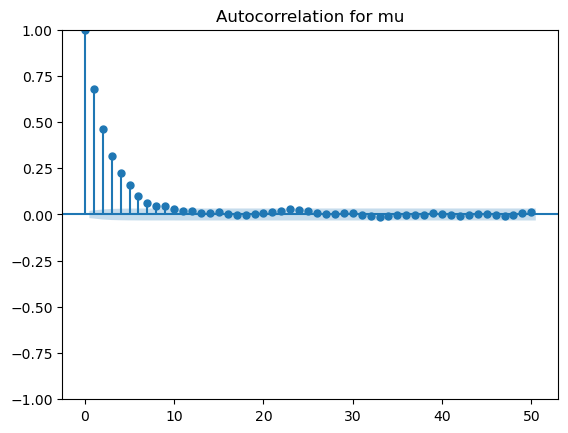

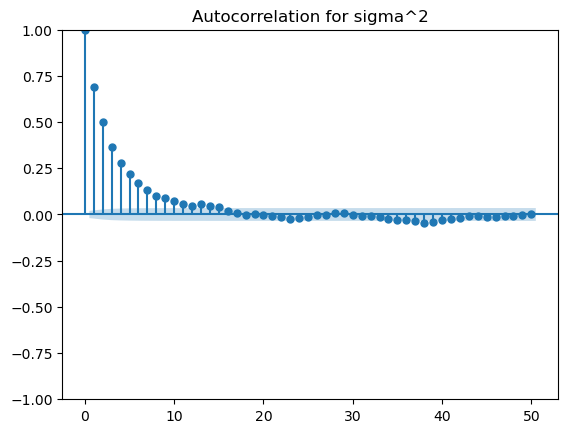

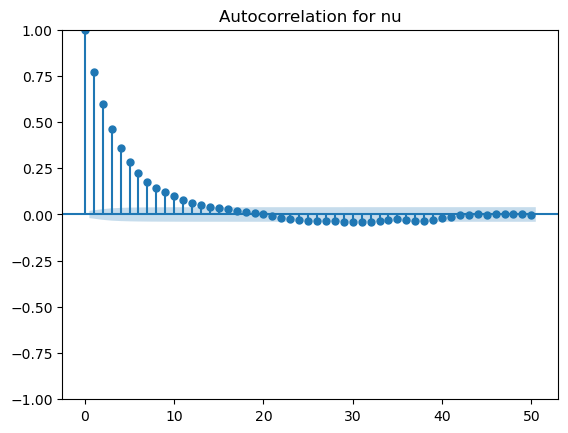

In [109]:
sm.graphics.tsa.plot_acf(mu_samples, lags=50)
plt.title("Autocorrelation for mu")
plt.show()

sm.graphics.tsa.plot_acf(sigma2_samples, lags=50)
plt.title("Autocorrelation for sigma^2")
plt.show()

sm.graphics.tsa.plot_acf(nu_samples, lags=50)
plt.title("Autocorrelation for nu")
plt.show()


The autocorrelation plots for $\mu, \sigma^2, \nu$ indicate that the MCMC sampler is performing well overall, still with some room for optimization.

## Q2

In [9]:
import numpy as np
import pymc
import arviz as az
from scipy import stats

In [14]:
sample_sizes = [50, 200, 500, 1000, 5000] # I want to compare between five different sample sizes.

#define the parameter
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

#storing result samples
results = {}

np.random.seed(366) #ensure reproducibility
for n in sample_sizes:
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)
    with pymc.Model() as model:
        mu = pymc.Normal("mu", mu=0, sigma=5) #prior of mu
        sigma = pymc.HalfNormal("sigma", sigma=1) #prior of sigma
        nu = pymc.DiscreteUniform("nu", lower=1, upper=100) #prior of nu
        likelihood_obs = pymc.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)
        fit_data = pymc.sample(5000, chains=2, tune=1000, return_inferencedata=True)
    results[n] = fit_data

for i in sample_sizes:
    print("Sample size:", i)
    print(az.summary(results[i], var_names=["nu"]))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  53.363  27.047    12.0     99.0       0.57    0.403    2178.0    2062.0   

    r_hat  
nu    1.0  
Sample size: 200
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  9.14  7.087     3.0     19.0       0.41    0.307     522.0     501.0   

    r_hat  
nu    1.0  
Sample size: 500
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.99  1.338     4.0      8.0       0.04    0.029    1149.0    1697.0   

    r_hat  
nu    1.0  
Sample size: 1000
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  3.92  0.543     3.0      5.0      0.021    0.015     648.0     660.0   

    r_hat  
nu   1.01  
Sample size: 5000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.146  0.354     5.0      6.0      0.013    0.009     758.0     752.0   

    r_hat  
nu    1.0  


From the summary table, we notice that for the very small sample size 50, the mean of $\nu$ is 53.363, which is very very far from our true $\nu = 5$. Also the credible interval is very wide, ranging from 12 to 99. Small sample size is also accompanied by a pretty high standard error (i.e. about 28). When we move to a bit larger sample size, say 200, the mean of $\nu$ moves a little bit close the true value, but not too much. It also has a pretty large standard error at 7 and a still wide credible interval. On the other hand when we have a large sample size, say 1000 the mean becomes 3.92 which is close to the true value, with much narrower credible interval and much smaller standard error (reducing uncertainty). Eventually when we have 5000 samples the mean value is 5.146, almost the same as our true $\nu$. This means that the inference is now very precise. And the standard error is as small as 0.354. Additionally, the $\hat{R}$ remains at 1.0, confirming MCMC convergence :)

## Q3

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

$$
=\int_0^{\infty} \sqrt{\frac{1}{2 \pi}} \sqrt{\tau_i} \exp \left(-\frac{1}{2} \tau_i y_i^2\right) \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\nu / 2-1} e^{\left(-\frac{\nu}{2} \tau_i\right)} d \tau_i
$$

$$
=\int_0^{\infty} \sqrt{\frac{1}{2 \pi}} {\tau_i}^{\frac{1}{2}} \exp \left(-\frac{1}{2} \tau_i y_i^2\right) \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\nu / 2-1} \exp {\left(-\frac{\nu}{2} \tau_i\right)} d \tau_i
$$

inside the integrand we have $${\tau_i}^{\frac{1}{2}} \tau_i^{\nu / 2-1} = {\tau_i}^{\frac{1}{2}+\frac{\nu}{2} -1}  = {\tau_i}^{\frac{v-1}{2}}$$
and
$$ \exp(-\frac{1}{2} \tau_i {y_i}^2) \exp (-\frac{\nu}{2} \tau_i) =\exp(-\frac{1}{2} \tau_i {y_i}^2 - \frac{\nu}{2} \tau_i) $$

so we have the integrand:
$$
\sqrt{\frac{1}{2 \pi}} \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu-1}{2}} \exp \left(-\frac{1}{2} \tau_i\left(y_i^2+\nu\right)\right) = {\frac{1}{\sqrt{2 \pi}}} \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu-1}{2}} \exp \left(-\frac{1}{2} \tau_i\left(y_i^2+\nu\right)\right) 
$$
Removing term, this is just
$$
\frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma(\frac{\nu}{2})} \tau_i^{\frac{\nu-1}{2}} \exp \left(-\frac{1}{2} \tau_i\left(y_i^2+\nu \right)\right) 
$$
So this is the kernel of Gamma distribution with update parameter :
$\alpha = \frac{\nu +1}{2}$ and $\lambda = \frac{y_i^2 +\nu}{2}$


where
$$
\int_0^{\infty} \tau_i^{\alpha-1} e^{- \lambda\tau_i} d \tau_i=\frac{\Gamma(\alpha)}{\lambda^{\alpha}}
$$

Hence we have: 

$$
\int p(y_i|\tau_i) p(\tau_i)  d\tau_i= {\frac{1}{\sqrt{2 \pi}}} \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu-1}{2}} \int \tau_i^{\frac{\nu-1}{2}-1} \exp \left(-\frac{1}{2} \tau_i\left(y_i^2+\nu \right)\right) d\tau_i
$$
The integrand is just equal to $$\frac{\Gamma(\alpha)}{\lambda^{\alpha}}$$, which is equal to $$\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{(\nu+1) / 2}}$$


Using the property of Gamma, we have
$$
\frac{\Gamma({\frac{\nu +1}{2}})}{\Gamma({\frac{\nu}{2}})} = \sqrt{\frac{\pi \nu}{2}} \frac{1}{B({\frac{\nu}{2}},{\frac{1}{2}})}
$$

which turns out to be $$
p\left(y_i\right)=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu \pi} \Gamma\left(\frac{\nu}{2}\right)}\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}
$$
And this is student t-distribution.
